# Robert Bubble Test ｡˚○ ｡˚○

<div class="alert alert-block alert-success">

## Part 2: `.yaml` file and executing the code

Since many aspects of the Robert bubble case are identical to the Straka case, with the exception of the set up, we will only highlight key differences in how the `.yaml` file and executable code are generated. 

</div>

<div class="alert alert-warning">

## $\texttt{PADDLE}$ Robert Initialization (Generation of .yaml file)

While we are not going to be generating the `.yaml` file in this notebook, we will go step-by-step through `robert.yaml` found in the same directory as this notebook. 

```yaml
geometry:
  type: cartesian
  bounds: {x1min: 0., x1max: 1.5e3, x2min: 0., x2max: 1.e3, x3min: -0.5, x3max: 0.5}
  cells: {nx1: 300, nx2: 200, nx3: 1, nghost: 3}

```
Here, we define a simulation domain that is 
1. 1.5 km high, with a resolution of 5 meters (# cells = 1500/5 = 300)
2. 1.0 km wide, with a resolution of 5 meters (# cells = 1000/5 = 200)
3. 2D simulation, so only one cell in the depth direction
4. Nominal 3 ghost zones

```yaml 
dynamics:
  equation-of-state:
    type: ideal-gas
    gammad: 1.4
    weight: 29.e-3
    limiter: false

  vertical-projection:
    type: temperature
    pressure-margin: 1.e-6

  reconstruct:
    vertical: {type: weno5, scale: false, shock: false}
    horizontal: {type: weno5, scale: false, shock: false}

  riemann-solver:
    type: lmars
```

These options are exactly the same as done for Straka, where the equation-of-state is in particular the same. 

```yaml
boundary-condition:
  external:
    x1-inner: reflecting
    x1-outer: reflecting
    x2-inner: reflecting
    x2-outer: reflecting
    x3-inner: reflecting
    x3-outer: reflecting
```

These options are exactly the same as done for Straka, where each boundary of the simulation is *reflecting*.

```yaml
integration:
  type: rk3
  cfl: 0.9
  implicit-scheme: 0
  nlim: -1
  tlim: 1080
  ncycle_out: 10
```

Here we define a simulation that lasts for 1080 simulation seconds (18 minutes long), with outputs printed to terminal/cell every 10 cycles. 

```yaml
forcing:
  const-gravity:
    grav1: -9.8

outputs:
  - type: restart
    dt: 300.
  - type: netcdf
    variables: [prim, uov]
    dt: 30.
```
These are also the same as done for Straka. We will have 1080/30=36 .nc output files, and restart files for 0, 300, 900, and 1080. 

<div class="alert alert-warning">

## $\texttt{PADDLE}$ Robert Executable Code 

Many of the components below are similar to Straka, so we will only highlight key differences! We will be going step-by-step through the `robert.py` found in the same directory as this notebook. 

<div class="alert alert-info">

## Robert Bubble Free Parameters

In **Part 1**, we defined a variety of free parameters that are specific to the physics of our problem. In particular, we defined 

1. The surface temperature (*T_s*) and pressure (*P_s*) of the background atmosphere 
2. The horizontal coordinate for the center of the bubble (*xc*) and the horizontal extent (*xr*)
3. The radius of the bubble (*a*), and the extent of the temperature gradient from the bubble (*s*)
4. The maximum temperature anomaly of the bubble (*dT*)

We additionally have something called *uniform_bubble*, that, (if True) will define a bubble without the temperature gradient around it (which is explored in the original Snap paper, [Li et al. (2019)](https://iopscience.iop.org/article/10.3847/1538-4365/aafdaa)). Feel free to explore this option!

Here we set them explicitly, as these are **not** part of the `.yaml` file. 

In [1]:
# Define the problem's free parameters

# Ps is the surface pressure
# 1 bar = 1e5 pascals 
Ps = 1.0e5 # in pascals

# surface temperature 
Ts = 303.15 # in K 

# Horizontal coordinate for center of bubble 
# In the center of the simulation
xc = 500.0 # in m 

# Vertical coordinate for center of bubble
# Slightly above the bottom of the simulation
zc = 260.0 # in m

# Maximum temperature anomaly 
dT = 0.5

# Radius of bubble 
a = 50.0 # meters

# Extent of temperature gradient from bubble's radius
s = 100.0 # meters

# Extra parameter to turn off/on on the temperature gradient from bubble's radius 
uniform_bubble = False

First, import the necessary packages.

In [2]:
# Torch is the basic computational backend, equivalent in some ways to numpy but can work on CPU and GPU
import torch

# Basic package for mathematical functions
import math

# kintera is a package developed by the same developers as PADDLE and CANOE that performs thermodynamic calculations 
# see https://github.com/chengcli/kintera
import kintera

# snapy is a package developed by the same developers as PADDLE and CANOE that performs dynamical calculations 
# see https://github.com/chengcli/snapy

# Here we import the main module (MeshBlock) and options (MeshBlockOptions) used in all PADDLE simulations (explained further below)
# and the named locations of density and pressure (which we use below to define our initial condition)
from snapy import MeshBlockOptions, MeshBlock
from snapy import kIDN, kIPR

# os is used to create the output directory for outputs 
import os 

<div class="alert alert-info">

## Creating custom user output variables 

$T = \frac{P}{R_d \rho}$

and potential temperature by 

$\theta = T(\frac{P_s}{P})^{\frac{R}{c_p}}$

In [3]:
# User defined function to generate user output variables (uov)

# Input : bvars (block_variables, stores all the variables in the simulation)
# we will generating the block variables object in the following cells to this one

# Output: dictionary with user output variables

def call_user_output(bvars):

    # Load in the primitive variables stored by the simulation 
    # As we will see in more detail in the cells below, hydro_w is a key that signifies the primitive variables 
    # where it stores each of the primitive variable values at each cell in the simulation 
    hydro_w = bvars["hydro_w"]

    # Create the user output variable dictionary 
    out = {}

    # Manually compute temperature and potential temperature 
    # from primitive variables and equation of state properties

    # kIPR = Index of Pressure 
    # kIDN = Index of Density  

    # Rd = specific gas constant
    # Ps = surface pressure
    # cp = specific heat capacity at const pressure 
    
    # Temperature 
    temp = hydro_w[kIPR] / (Rd * hydro_w[kIDN])

    # Define it in output dictionary 
    out["temp"] = temp
    
    # Potential Temperature 
    theta = temp * (Ps / hydro_w[kIPR]).pow(Rd / cp)

    # Define it in output dictionary 
    out["theta"] = theta

    # Output the user output variable dictionary 
    return out

<div class="alert alert-info">

## Generate the $\texttt{MeshBlock}$ Object

<div>

In [4]:
# set hydrodynamic options from our yaml file
op = MeshBlockOptions.from_yaml("./robert.yaml")

# Set output directory 
output_directory = './robert_results/'
os.makedirs(output_directory, exist_ok=True)
op.output_dir(output_directory)

# initialize block 
block = MeshBlock(op)

[HydroOptions] -- constant gravity options --
* grav1 = -9.8
* grav2 = 0
* grav3 = 0


[W219 16:31:41.644103000 ProcessGroupGloo.cpp:757] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())


In [5]:
# get handles to specific modules

# Coordinates of simulation domain stored in MeshBlock
# We will need this to generate the meshgrid we will define our initial condition of the simulation on top of 
coord = block.module("coord")

# Equation of state properties stored in MeshBlock
# We will need this to generate our thermodynamic constants used when defining our initial condition 
eos = block.module("hydro.eos")

# Vertical gravity stored in MeshBlock (initialized by MeshBlockOptions)
# We will need this to generate our initial temperature condition (see Part 1, dT/dz)
grav = -block.options.hydro().grav().grav1()

In [6]:
# thermodynamic constants 

# Here we highlight an alternative way to generate c_p
# Which is mathematically equivalent to the one we define in Straka

# Adiabatic constant
# We defined this as gammad in the dynamics dictionary of the .yaml file 
gamma = eos.options.gammad()

# Specific gas constant
# We defined the molecular weight (M) in the dynamics dictionary of the .yaml file 
# Used in call_user_output to get temperature and potential temperature
# Used to set initial condition of temperature and pressure
Rd = kintera.constants.Rgas / eos.options.weight()

# Specific heat capacity at constant pressure 
# Used in call_user_output to get temperature and potential temperature
# Used to set initial condition of temperature and pressure
cp = gamma / (gamma - 1.0) * Rd

<div class="alert alert-info">

## Creating the Initial Condition

Now, we want to actually define our simulation's initial condition. 

In order to do this, we follow a similar flow as we did in **Part 1**, where we create our 3-dimensional grid and then define the primitive variables at each point in the grid. 

<div>

In [7]:
# Setup the meshgrid for the simulation

# coord.buffer("x1v") 
# returns a 1D tensor with length = number of cells in x1 direction + 2 x ghost zones
# As defined in the .yaml file, this would be 64 cells + 2 x 3 ghost zones = 70

x3v, x2v, x1v = torch.meshgrid(
    coord.buffer("x3v"), coord.buffer("x2v"), coord.buffer("x1v"), indexing="ij"
)

# The number of points in each dimension
# This is identical to the number of cells 
nc3 = coord.buffer("x3v").shape[0]
nc2 = coord.buffer("x2v").shape[0]
nc1 = coord.buffer("x1v").shape[0]

In [8]:
# Hardcode the number of variables (5 = number of primitive variables)
nvar = 5

# Define a 4D tensor storing primitive variables at each simulation coordinate
# In athena++, w signifies the primitive variables 
w = torch.zeros((nvar, nc3, nc2, nc1), device='cpu')

# Define the spatial extent of the bubble as we did in Part 1
r = torch.sqrt((x2v - xc) ** 2 + (x1v - zc) ** 2)

# Set the temperature field of the entire simulation 
# As we did in Part 1, see dT/dz
temp = Ts - grav * x1v / cp

# Initial Condition of the full Atmosphere's Pressure Field, defined as done in Part 1
# Recall we define pressure before applying the bubble's temperature anomaly
# since pressure equilibrates at the speed of sound
w[kIPR] = Ps * torch.pow(temp / Ts, cp / Rd)

# Add the temperature anomaly of the bubble to the temperature field
temp += torch.where(r <= a, dT, 0.0)

# Add the temperature gradient around the bubble 
if not uniform_bubble:
    temp += torch.where(
        r > a,
        dT * torch.exp(-(((r - a) / s) ** 2)),
        0.0,
    )

# Initial Condition of the full Atmosphere's Density Field, defined as done in Part 1
w[kIDN] = w[kIPR] / (Rd * temp)

In [9]:
# Create an empty block variables dictionary
block_vars = {}

# Populate the primitive variables with the initial condition we created above
block_vars["hydro_w"] = w

# Initialize the MeshBlock (block) object with the block variables 
block_vars, current_time = block.initialize(block_vars)

# Let the simulation know we created a custom call_user_output function 
# to output temperature and potential_temperature
block.set_user_output_func(call_user_output)

<div class="alert alert-info">

## Run the simulation!

Below, we actually start integrating the model.

The code below will be more-or-less the same for all $\texttt{PADDLE}$ python scripts, and can be taken as-is for now. 

Unlike Straka, the simulation below will be much slower, taking about **30-45 minutes** to run in a Jupyter notebook, and therefore might be more suited for running with multiple cores on terminal (which we show how to do in **Part 4**). 

<div>

In [10]:
# Initialize the output before the simulation starts, compute until the desired time 
block.make_outputs(block_vars, current_time)

# Run the simulation in a loop
while not block.intg.stop(block.inc_cycle(), current_time):

    # Each time step of the simulation is determined by the cfl number and the sound speed 
    dt = block.max_time_step(block_vars)

    # Output to let us know the code is running
    block.print_cycle_info(block_vars, current_time, dt)

    # For each cycle, a multi-stage method (here rk3) is used to advance block_vars
    for stage in range(len(block.intg.stages)):
        block.forward(block_vars, dt, stage)

    # Check for any errors
    err = block.check_redo(block_vars)
    if err > 0:
        continue  # redo current step
    if err < 0:
        break  # terminate

    # Progress the time and make outputs 
    current_time += dt
    block.make_outputs(block_vars, current_time)

# Make the final outputs and clean up the internal states in MeshBlock
block.finalize(block_vars, current_time)

cycle=10 redo=0 time=1.16106585476093e-01 dt=1.29007318427642e-02 mass0=1.62395950828026e+06 energy=3.44541893920548e+11
cycle=20 redo=0 time=2.45113907265395e-01 dt=1.29007328381806e-02 mass0=1.62395950828026e+06 energy=3.44541893640632e+11
cycle=30 redo=0 time=3.74121247438781e-01 dt=1.29007360107158e-02 mass0=1.62395950828026e+06 energy=3.44541893164725e+11
cycle=40 redo=0 time=5.03128634265905e-01 dt=1.29007425745800e-02 mass0=1.62395950828026e+06 energy=3.44541892503517e+11
cycle=50 redo=0 time=6.32136087282165e-01 dt=1.29007471149085e-02 mass0=1.62395950828026e+06 energy=3.44541891678696e+11
cycle=60 redo=0 time=7.61143555844358e-01 dt=1.29007454517411e-02 mass0=1.62395950828026e+06 energy=3.44541890722218e+11
cycle=70 redo=0 time=8.90150981118793e-01 dt=1.29007379720321e-02 mass0=1.62395950828026e+06 energy=3.44541889670818e+11
cycle=80 redo=0 time=1.01915830952285e+00 dt=1.29007259542414e-02 mass0=1.62395950828026e+06 energy=3.44541888560646e+11
cycle=90 redo=0 time=1.148165507

<div class="alert alert-warning">

## $\texttt{PADDLE}$ Robert Results

Here, we just combine the .nc files, view them in both ncview and in the notebook. 

In [11]:
!(cd ./robert_results && pd-combine 1 -o main)

##########################
## Combine output files ##
##########################
Working on case robert...
Combining FITS output ...
Concatenating output field out1 ...
Combining output fields:  1 to main
Done.



In [12]:
!(cd ./robert_results && ncview robert-main.nc)

Ncview 2.1.8 David W. Pierce  8 March 2017
http://meteora.ucsd.edu:80/~pierce/ncview_home_page.html
Copyright (C) 1993 through 2015, David W. Pierce
Ncview comes with ABSOLUTELY NO WARRANTY; for details type `ncview -w'.
This is free software licensed under the Gnu General Public License version 3; type `ncview -c' for redistribution details.

Note: no Ncview app-defaults file found, using internal defaults
calculating min and maxes for press...
calculating min and maxes for vel1...


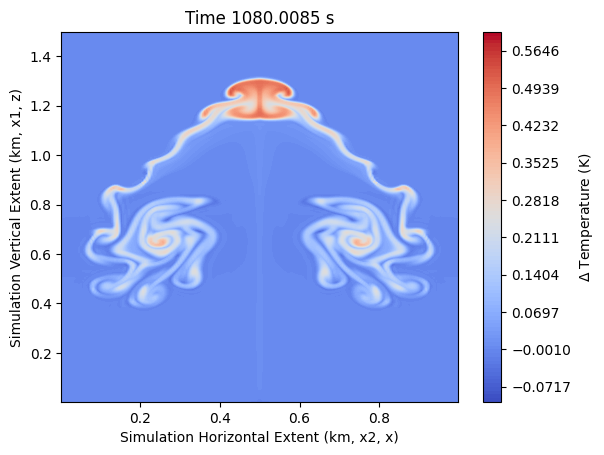

In [13]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import netCDF4
import numpy as np
import time


# Open the file
robert_output = netCDF4.Dataset('./robert_results/robert-main.nc', 'r')

# Lets plot the temperature 
data_temperature = robert_output.variables['temp'][:]

# Array of time for each frame, in seconds
data_time = robert_output.variables['time'][:]

# Array of center of cells for vertical direction
data_x1 = robert_output.variables['x1'][:]

# Array of center of cells for horizontal direction
data_x2 = robert_output.variables['x2'][:]

# Create meshgrid in order to plot 
Z, X = np.meshgrid(data_x2, data_x1)

# Initial temperature map to provide contrast for colormap below
temp_no_bubble = Ts - grav*X/cp

# Loop over the time saved frames 
for t in range(np.shape(data_temperature)[0]):

    # Ensures that the last plot will be cleared 
    clear_output(wait = True)

    # Make a countour plot with really fine layers to capture eddies
    plt.contourf(Z/1000,X/1000,data_temperature[t,:,0,:]-temp_no_bubble,cmap = 'coolwarm', levels = np.linspace(-0.1,0.6, 100))
    plt.colorbar(label = '$\Delta$ Temperature (K)')
    title = 'Time ' + str(data_time[t]) + ' s'
    plt.title(title)
    plt.xlabel('Simulation Horizontal Extent (km, x2, x)')
    plt.ylabel('Simulation Vertical Extent (km, x1, z)')
    plt.show()

    # Delay, so that it doesn't go too fast 
    time.sleep(0.1)
